In [1]:
import os
import torch
import ds.paths as d_path
import torchvision

from utils.init import reproducibility, clean_memory_get_device
from config import ConfigArgs
from utils.train import EarlyStopper, TrainingInfo, epoch_end_print, get_dataloaders, get_datasets, check_best, end_train, evaluate, train_one_epoch
from torchvision.models import resnet18, ResNet18_Weights
from utils.plot import plot_losses
from IPython.display import clear_output
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from ds.reflacx.lesion_detection import REFLACXLesionDetectionDataset
from engine.classification import ClassificationEvaluator, load_cl_pretrained, resnet_set_trainable_layers
from models.classification import MultiBinaryClassificationModel
from utils.plot import plot_train

import warnings
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large 

In [3]:
image_size = 128
batch_size = 32
epochs = 50
linear_eval = False

In [4]:
from torch import nn
from ds.reflacx.chexpert import REFLACXCheXpertDataset
from utils.train import get_dataloader_g
import torch.utils.data as data
import math
import numpy as np

# load the model
model = resnet18(weights=None)

cl_model_name = "our_simclr"

train_d = data.DataLoader(
    REFLACXCheXpertDataset(image_size=image_size, use_aug=False, split_str="train"),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)


# load weights into this backbone then apply fpn.

cp = torch.load(
    os.path.join("checkpoints", cl_model_name, "model"), map_location=device
)

backbone_cp_dict = param_dict = {
    k.replace("img_enc.", ""): v
    for k, v in cp["model"].items()
    if k.startswith("img_enc.")
}

del backbone_cp_dict['fc.weight']
del backbone_cp_dict['fc.bias']

model.load_state_dict(backbone_cp_dict, strict=False)

if linear_eval == True:
    for param in model.parameters():
        param.requires_grad_(False)

model.fc = nn.Linear(
    512,
    train_d.dataset.num_classes(),
)

optimizer = torch.optim.AdamW(
    params=[p for p in model.parameters() if p.requires_grad],
    lr=3e-4,
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=math.ceil(len(train_d.dataset) / batch_size)
    * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
    eta_min=1e-8,
)

In [5]:
criterion = nn.BCELoss()

In [6]:
import torch.nn.functional as F

def train_one_epoch(
    model,
    criterion,
    optimizer,
    dataloader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):

    model.to(device)
    model.train()
    iters = math.ceil(len(dataloader.dataset) / train_d.batch_size)
    evaluator = ClassificationEvaluator()

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    losses = []
    for i, (x, y) in enumerate(dataloader):
        output = model(x.to(device))
        loss = criterion(F.sigmoid(output), y.to(device).float())
        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        evaluator.update(F.sigmoid(output), y)
        
        if lr_scheduler is not None:
            if isinstance(
                lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
            ):
                lr_scheduler.step(epoch + i / iters)
            else:
                lr_scheduler.step()
        losses.append(loss.item())
    print(evaluator.gts)
    print(evaluator.preds)
    return (losses, evaluator.get_performance()["top-1-acc"])

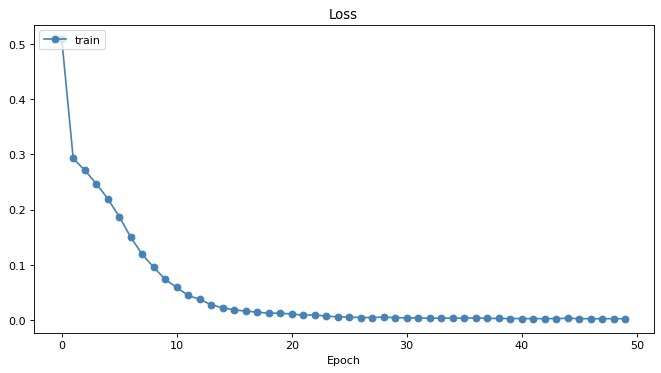

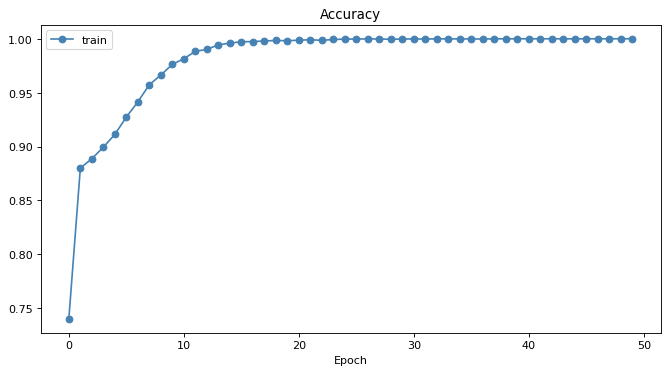

In [7]:
train_losses = []
train_accs = []
for epoch in range(epochs):
    train_l, train_acc = train_one_epoch(
        model,
        criterion,
        optimizer,
        train_d,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    train_losses.append(np.mean(train_l))   
    train_accs.append(train_acc)
    clear_output()
    plot_train(train_losses, title="Loss")
    plot_train(train_accs, title="Accuracy")


In [8]:
@torch.inference_mode()
def evaluate(model, data_loader, device):
    model.to(device)
    model.eval()
    evaluator = ClassificationEvaluator()
    for _, (x,y) in enumerate(data_loader):
        output = model(x.to(device))
        evaluator.update(F.sigmoid(output), y)

    return evaluator.get_performance()

In [9]:
test_d = data.DataLoader(
    REFLACXCheXpertDataset(image_size=image_size, use_aug=False, split_str="test"),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)

test_p = evaluate(
    model=model,
    data_loader=test_d,
    device=device,
)

In [10]:
test_p

{'f1': 0.5490430622009569,
 'precision': 0.574468085106383,
 'accuracy': 0.8816326530612245,
 'recall': 0.5257731958762887,
 'auc': 0.7319606383238092,
 'top-1-acc': tensor(0.8816)}